This notebook is used to compare GCM data with AWS data, or one GCM against another to look for apparent biases or calibrate parameters to match data. This includes code to calibrate kp (multiplicative precipitation factor) to field winter mass balance data.

In [497]:
import xarray as xr 
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [498]:
# INPUTS
var = 'temp'      # Variable to compare
GCM = 'MERRA2'  # GCM to extract ('MERRA2','ERA5',' or 'BOTH')
by = 'glacier' # 'glacier' or 'latlon'
start = pd.to_datetime('2000-01-01 00:00')
end = pd.to_datetime('2018-12-31 00:00')

# necessary initialization
units_checked = False
all_vars = {'temp':{'MERRA2':'T2M','ERA5':'t2m'},
            'tp':{'MERRA2':'PRECTOTCORR','ERA5':'tp'},
            'rh':{'MERRA2':'RH2M','ERA5':'rh'},
            'SWin':{'MERRA2':'SWGDN','ERA5':'ssrd'},
            'LWin':{'MERRA2':'LWGAB','ERA5':'strd'},
            'uwind':{'MERRA2':'U2M','ERA5':'u10'},
            'vwind':{'MERRA2':'V2M','ERA5':'v10'},
            'sp':{'MERRA2':'PS','ERA5':'sp'},
            'tcc':{'MERRA2':'CLDTOT','ERA5':'tcc'}}

In [499]:
# FILEPATHS
fp_clim = '~/research/climate_data/'
fp_MERRA2 = os.path.join(fp_clim,'MERRA2/VAR/MERRA2_VAR_LAT_LON.nc')
fp_ERA5 = os.path.join(fp_clim,'ERA5/ERA5_hourly/ERA5_VAR_hourly.nc')
fp_AWS = os.path.join(fp_clim,'AWS/Gulkana/LVL2/gulkana1480_hourly_LVL2.csv')
fp_RGI = '~/research/RGI/rgi60/00_rgi60_attribs/01_rgi60_Alaska.csv'


In [501]:
# Define the latitude and longitude of the gridcell to grab
if by == 'glacier':
    # fill out glac_no and glacier_name for getting AWS data
    glac_no = '01.00570'
    glacier_name = 'gulkanaD'

    # extract lat/lon of glacier
    glacier_table = pd.read_csv(fp_RGI)
    glacier_table = glacier_table.loc[glacier_table['RGIId'] == 'RGI60-'+glac_no]
    cenlat = glacier_table['CenLat'].to_numpy()[0]
    cenlon = glacier_table['CenLon'].to_numpy()[0]
elif by == 'latlon':
    # fill out cenlat and cenlon to extract data from
    cenlat = 63.3
    cenlon = -135

In [502]:
# Open GCM dataset for the variable of interest
if GCM in ['MERRA2','BOTH']:
    file_lat = str(int(np.floor(cenlat/10)*10))
    file_lon = str(int(np.floor(cenlon/10)*10))
    fn_MERRA2 = fp_MERRA2.replace('LAT',file_lat).replace('LON',file_lon)
    fn_MERRA2 = fn_MERRA2.replace('VAR',all_vars[var]['MERRA2'])
    ds_MERRA2 = xr.open_dataset(fn_MERRA2)
    latname = 'lat'
    lonname = 'lon'
    elevname = 'PHIS'

if GCM in ['ERA5','BOTH']:
    fn_ERA5 = fp_ERA5.replace('VAR',var)
    ds_ERA5 = xr.open_dataset(fn_ERA5)
    latname = 'latitude'
    lonname = 'longitude'
    elevname = 'z'

In [503]:
def extract_latlon(ds,eds):
    """
    Selects the closest latitude and longitude gridcell
    from a GCM dataset to the input cenlat, cenlon coordinates.
    Also returns the geopotential of that gridcell converted
    to elevation units (m)
    """
    # get latitude and longitude of nearest GCM point
    datalat = ds.coords[latname][:].values
    datalon = ds.coords[lonname][:].values
    lat_nearidx = np.abs(cenlat - datalat).argmin()
    lon_nearidx = np.abs(cenlon - datalon).argmin()
    lat = datalat[lat_nearidx]
    lon = datalon[lon_nearidx]

    if GCM == 'ERA5':
        lat = lat.round(2)
        lon = lon.round(2)
        if var == 'tcc':
            lat = lat.round(1)
            lon = lon.round(1)

    # select dataset by closest lat/lon to glacier center
    ds = ds.sel({latname:lat,lonname:lon}).drop_vars([latname,lonname])
    eds = eds.sel({latname:lat,lonname:lon})
    elev = eds[elevname].to_numpy()[0] / 9.81
    return ds,elev

In [504]:
# run function to select lat lon and select dataset by time
if 'MERRA2' == GCM:
    start_M = start + pd.Timedelta(minutes=30)
    end_M = end + pd.Timedelta(minutes=30)
    eds = xr.open_dataset('~/research/climate_data/MERRA2/MERRA2constants.nc4')
    ds_GCM,elev = extract_latlon(ds_MERRA2,eds)
    ds_GCM = ds_GCM.sel(time=pd.date_range(start_M,end_M,freq='h'))
elif 'ERA5' == GCM:
    eds = xr.open_dataset('~/research/climate_data/ERA5/ERA5_hourly/ERA5_geopotential.nc')
    ds_GCM,elev = extract_latlon(ds_ERA5,eds)
    ds_GCM = ds_GCM.sel(time=pd.date_range(start,end,freq='h'))

In [505]:
# input processing of AWS dataset
AWS_elev = 1480
df_AWS = pd.read_csv(fp_AWS)
df_AWS = df_AWS.set_index(pd.to_datetime(df_AWS['local_time']))
df_AWS.fillna({'Precip_Weighing_Incremental':df_AWS['Precip_Stage_Incremental']*1.48},inplace=True)
df_AWS = df_AWS.loc[pd.date_range(start,end,freq='h')]
# df_AWS = df_AWS['Precip_Weighing_Incremental']
df_AWS = df_AWS['site_temp_USGS']

In [506]:
# RESAMPLE
if var in ['tp']:
    df_AWS = df_AWS.resample('ME').sum()
    ds_GCM = ds_GCM.resample(time='ME').sum()
else:
    df_AWS = df_AWS.resample('ME').mean()
    ds_GCM = ds_GCM.resample(time='ME').mean()

In [507]:
# UNITS
if not units_checked:
    if var == 'tp':
        df_AWS = df_AWS / 1000
        ds_GCM = ds_GCM * 3600 / 1000
    elif var == 'temp':
        ds_GCM = ds_GCM - 273.15
    print(f'Adjusting to {AWS_elev - elev:.1f} m elevation change from geopotential to the AWS elevation')
    print(f'(temperature change of {-0.0065*(AWS_elev - elev) :.3f} C)')
    ds_GCM = ds_GCM - 0.0065*(AWS_elev - elev)
    units_checked = True

Adjusting to 247.2 m elevation change from geopotential to the AWS elevation
(temperature change of -1.607 C)


In [513]:
df_AWS = df_AWS.resample('YE').mean()
ds_GCM = ds_GCM.resample(time='YE').mean()
# ds_GCM_ERA5 = ds_GCM_ERA5.resample(time='YE').mean()

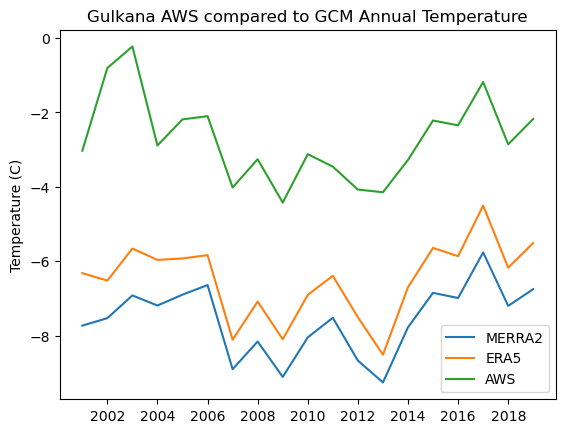

In [515]:
plt.plot(ds_GCM['time'],ds_GCM[all_vars[var][GCM]].values,label=GCM)
plt.plot(ds_GCM['time'],ds_GCM_ERA5[all_vars[var]['ERA5']].values,label='ERA5')
plt.plot(df_AWS.index,df_AWS.to_numpy(),label='AWS')

plt.legend()
plt.title('Gulkana AWS compared to GCM Annual Temperature')
plt.ylabel('Temperature (C)')
plt.show()

CODE BELOW IS USED TO GET A NEW PRECIPITATION FACTOR TO MATCH WINTER MASS BALANCE DATA TO PRECIPITATION

In [304]:
# REGRESS FOR KP
site = 'B'
var = 'tp'
fp_MB = '/home/claire/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'
df_mb = pd.read_csv(fp_MB)
df_mb = df_mb.loc[df_mb['site_name'] == site]
years_mb = np.unique(df_mb['Year'])

df_clim,elev = extract_latlon(ds_MERRA2).to_dataframe()
df_clim = pd.DataFrame({'tp':df_clim[all_vars['tp'][GCM]].values,
                        'Year':[time.year for time in df_clim.index]},
                        index=df_clim.index)
years_clim = np.unique(df_clim['Year'])

# get intersecting years
years = np.array(list(set(years_mb) & set(years_clim)))
years = years[1:]

# plot MB data
winter_mb_data = df_mb['bw'].loc[df_mb['Year'].isin(years)]

tp_measured = []
for year in years:
    # get dates
    previous_fall_date = df_mb.loc[df_mb['Year']==year-1]['spring_date'].to_numpy()[0]
    spring_date = df_mb.loc[df_mb['Year']==year]['spring_date'].to_numpy()[0]
    acc_dates = pd.date_range(previous_fall_date,spring_date,freq='h')
    try:
        df_clim.loc[acc_dates]
    except:
        acc_dates = acc_dates + pd.Timedelta(minutes=30)
    # fall_date = df_mb.loc[df_mb['Year']==year]['fall_date'].to_numpy()[0]
    # next_spring_date = df_mb.loc[df_mb['Year']==year+1]['spring_date'].to_numpy()[0]
    # if str(fall_date) == 'nan':
    #     fall_date = str(year) + '-08-10 00:00'
    # acc_dates = pd.date_range(fall_date,next_spring_date,freq='h')
    # acc_dates = acc_dates + pd.Timedelta(minutes=30)

    # sum mass balance
    tp = df_clim['tp'].loc[acc_dates].to_numpy() * 3600 / 1000
    bw = np.sum(tp[~np.isnan(tp)])
    tp_measured.append(bw)
tp_measured = np.array(tp_measured)

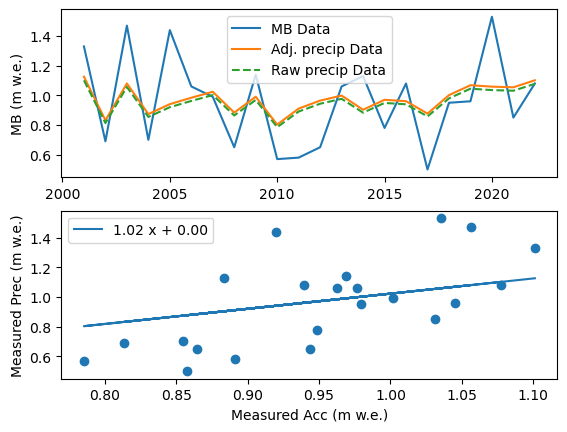

In [517]:
# get slope
include_intercept = False
if include_intercept:
    X = np.vstack([tp_measured,np.ones(len(tp_measured))]).T
    result = np.linalg.lstsq(X,winter_mb_data,rcond=None)[0]
    slope = result[0]
    intercept = result[1]
else:
    X = tp_measured.reshape(-1,1)
    result = np.linalg.lstsq(X,winter_mb_data,rcond=None)[0]
    slope = result[0]
    intercept = 0

fig,ax = plt.subplots(2)
ax[0].plot(years,winter_mb_data,label='MB Data')
ax[0].plot(years,tp_measured * slope + intercept,label='Adj. precip Data')
ax[0].plot(years,tp_measured,'--',label='Raw precip Data')
ax[0].legend()
ax[0].set_ylabel('MB (m w.e.)')

ax[1].scatter(tp_measured,winter_mb_data)
x = tp_measured.copy()
line_label = f'{slope:.2f} x + {intercept:.2f}'
ax[1].plot(x, x*slope+intercept,label=line_label)
ax[1].legend()
ax[1].set_xlabel('Measured Acc (m w.e.)')
ax[1].set_ylabel('Measured Prec (m w.e.)')
plt.show()